# Telecom Churn Project 

## Final Model Fit and Graphing

This notebook fits each of the models tested the Model Search notebook with the parameters that were generated by the grid search.  The output of each model is used to create ROC-AUC curves, confusion matrices and other metrics for model comparison.  From this comparison data I will select a single model as the 'best' for my problem and use that model in the Model Evaluation notebook for final model evaluation.

In [1]:
import os
import sys
import time

import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

# These are tools that I created for model data generation
sys.path.append('../src')
from my_eval_tools import calc_roc_data
from my_eval_tools import calc_hybrid_roc_data 
from my_eval_tools import hybrid_predict, hybrid_predict_proba
from my_eval_tools import calc_pr_sweep
from my_eval_tools import predict_sweep


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, roc_curve
from sklearn.metrics import recall_score, precision_recall_curve
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

Using TensorFlow backend.


Read the training data file.  This csv file was created from the original Telecom data file and was cleaned and scaled before it was put into a second csv file to make a milestone for this work.  Specifically, this file was created by running the notebooks:
* Telecom to SQL
* Telecom clean and eda

In [3]:
# Read the csv file save by the clean/eda notebook
train_df = pd.read_csv('../data/churn_train_clean.csv').drop('Unnamed: 0', axis=1)


In [4]:
# Define which columns we're going to use in our modeling.
train_columns1 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', \
       'Month-to-month', 'One year', 'Fiber optic', 'Female']

train_columns2 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'tenure', 'PhoneService', 'MultipleLines',  \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', \
       'Month-to-month', 'One year', 'Fiber optic', 'MonthlyCharges', 'Female']

train_columns = train_columns2

X = train_df[train_columns]
y= train_df['Churn']

In [5]:
# Split the original dataset into train and validation groups
#  set stratify to true so both classes are represented it the splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Make a balance set for model training
sm = SMOTE(random_state=42)
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

----

### Best model for Logistic Regression

----

F1 Scoring
```Python
score = 0.60
{'LOG__C': 10, 'LOG__penalty': 'l2', 'LOG__solver': 'liblinear', 'smt__random_state': 45}
```

Recall Scoring
```Python
recall
score = 0.76
{'LOG__C': 0.01, 'LOG__penalty': 'l1', 'LOG__solver': 'liblinear', 'smt__random_state': 45}

```

In [6]:
log_best = LogisticRegression(C=0.03, penalty='l2', solver='liblinear', random_state=45)
log_best.fit(X_train_smt,y_train_smt)
log_y_hat = log_best.predict(X_test)
print(accuracy_score(y_test, log_y_hat))

0.7757805108798487


In [7]:
roc_data_log = calc_roc_data(log_best, X_test, y_test, 20)

In [11]:
log_y_hat_proba = log_best.predict_proba(X_test)
roc_auc_score(y_test, log_y_hat_proba[:,1])
roc_fpr, roc_tpr, roc_log_threshold = roc_curve(y_test, log_y_hat_proba[:,1])

In [12]:
x_plt_log = [roc_data_log[i][1] for i in range(len(roc_data_log))]
y_plt_log = [roc_data_log[i][2] for i in range(len(roc_data_log))]


----

### Best model for KNN

----

score = 0.53
{'KNN__n_neighbors': 6, 'smt__random_state': 45}

'''
recall
score = 0.75
{'KNN__n_neighbors': 10, 'smt__random_state': 45}

'''

In [13]:
knn_best = KNeighborsClassifier(n_neighbors=10)
knn_best.fit(X_train_smt, y_train_smt)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [14]:
knn_y_hat_proba = knn_best.predict_proba(X_test)
roc_auc_score(y_test, knn_y_hat_proba[:,1])

0.8057692485292896

In [15]:
roc_data_knn = calc_roc_data(knn_best, X_test, y_test, 20)
x_plt_knn = [roc_data_knn[i][1] for i in range(len(roc_data_knn))]
y_plt_knn = [roc_data_knn[i][2] for i in range(len(roc_data_knn))]

----

# Best model for Random Forest Classifier

----

score = 0.61
{'RFC__criterion': 'gini', 'RFC__max_depth': 4, 'RFC__max_features': 5, 'RFC__n_estimators': 1000, 'RFC__random_state': 42, 'smt__random_state': 10}
'''
recall
score = 0.86
{'RFC__criterion': 'entropy', 'RFC__max_depth': 2, 'RFC__max_features': 10, 'RFC__n_estimators': 1000, 'RFC__random_state': 42, 'smt__random_state': 10}
'''

In [16]:
rf_best = RandomForestClassifier(max_depth=2, max_features=10, n_estimators=1000, criterion='entropy', random_state=42)

In [17]:
rf_best.fit(X_train_smt, y_train_smt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
rf_y_hat_proba = rf_best.predict_proba(X_test)
roc_auc_score(y_test, rf_y_hat_proba[:,1])

0.8409924178757123

In [19]:
roc_data_rf = calc_roc_data(rf_best, X_test, y_test, 40)
x_plt_rf = [roc_data_rf[i][1] for i in range(len(roc_data_rf))]
y_plt_rf = [roc_data_rf[i][2] for i in range(len(roc_data_rf))]

----

## Best model for Support Vector Classifier

----

score = 0.63
{'SVC__C': 1.5, 'SVC__kernel': 'rbf', 'SVC__random_state': 42, 'smt__random_state': 10}

'''
recall
score = 0.78
{'SVC__C': 1, 'SVC__kernel': 'rbf', 'SVC__random_state': 42, 'smt__random_state': 10}
'''

In [20]:
svc_best = SVC(C=1.5, kernel='rbf', random_state = 42, probability=True)

In [21]:
svc_best.fit(X_train_smt, y_train_smt)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [22]:
svc_y_hat_proba = svc_best.predict_proba(X_test)
roc_auc_score(y_test, svc_y_hat_proba[:,1])

0.8423615408058662

In [23]:
roc_data_svc = calc_roc_data(svc_best, X_test, y_test, 40)
x_plt_svc = [roc_data_svc[i][1] for i in range(len(roc_data_svc))]
y_plt_svc = [roc_data_svc[i][2] for i in range(len(roc_data_svc))]

----

## Best model for Naive Bayes

----

score = 0.59
{'NB__var_smoothing': 0.0, 'smt__random_state': 45}

'''
recall
score = 0.78
{'NB__var_smoothing': 20, 'smt__random_state': 45}
'''

In [24]:
nb_best = GaussianNB()

In [25]:
nb_best.fit(X_train_smt, y_train_smt)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
nb_y_hat_proba = nb_best.predict_proba(X_test)
roc_auc_score(y_test, nb_y_hat_proba[:,1])

0.8159949575641157

In [27]:
roc_data_nb = calc_roc_data(nb_best, X_test, y_test, 40)
x_plt_nb = [roc_data_nb[i][1] for i in range(len(roc_data_nb))]
y_plt_nb = [roc_data_nb[i][2] for i in range(len(roc_data_nb))]

In [28]:
#read the roc data from the hybrid model
roc_data_hybrid = pickle.load( open('roc_hybrid.pkl', 'rb'))

In [29]:
x_plt_hybrid = [roc_data_hybrid[i][1] for i in range(len(roc_data_hybrid))]
y_plt_hybrid = [roc_data_hybrid[i][2] for i in range(len(roc_data_hybrid))]

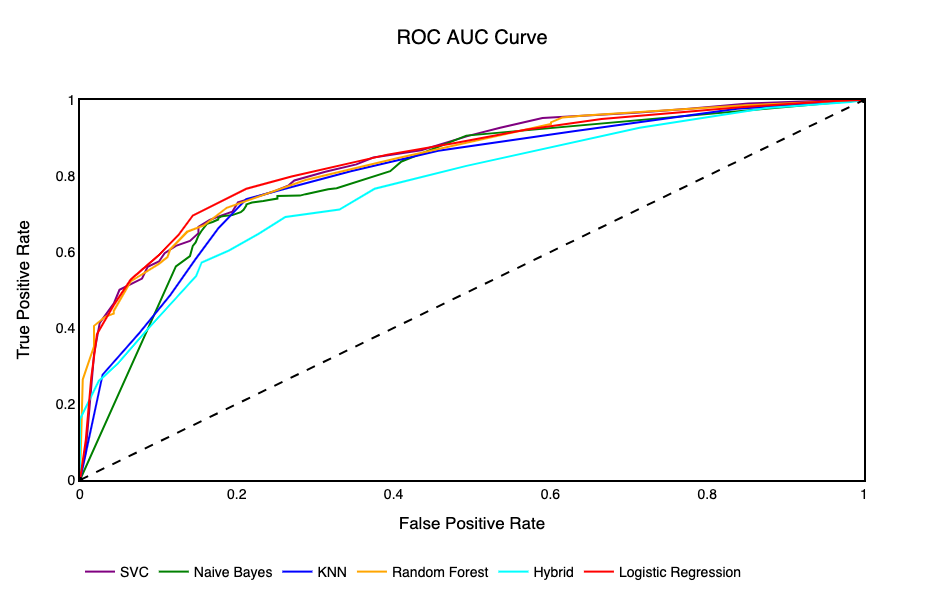

In [31]:
layout = go.Layout(paper_bgcolor = 'rgba(0,0,0,0)', 
            plot_bgcolor = 'rgba(0,0,0,0)',
            width=800, height=600)

fig = go.Figure(layout=layout)

fig.add_trace(go.Line(x=x_plt_svc, y=y_plt_svc, mode='lines', name='SVC', line=dict(color='purple', width=2)))
fig.add_trace(go.Line(x=x_plt_nb, y=y_plt_nb, mode='lines', name='Naive Bayes', line=dict(color='green', width=2)))
fig.add_trace(go.Line(x=x_plt_knn, y=y_plt_knn, mode='lines', name='KNN', line=dict(color='blue', width=2)))
fig.add_trace(go.Line(x=x_plt_rf, y=y_plt_rf, mode='lines', name='Random Forest', line=dict(color='orange', width=2)))
fig.add_trace(go.Line(x=x_plt_hybrid, y=y_plt_hybrid, mode='lines', name='Hybrid', line=dict(color='cyan', width=2)))
fig.add_trace(go.Line(x=x_plt_log, y=y_plt_log, mode='lines', name='Logistic Regression', line=dict(color='red', width=2)))
fig.add_trace(go.Line(x=[0,1], y=[0,1], line=dict(color='black', width=2, dash='dash'), showlegend=False))

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, showgrid=False, zeroline=False, range=[0,1])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True, showgrid=False, zeroline=False, range=[0,1])


fig.update_layout(
    title={
        'text': "ROC AUC Curve",
        'x': 0.5, 'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'},
    
        font=dict(
            family="Helvetica",
            size=20,
            color="black"
        ))

fig.update_layout(legend_orientation = 'h',
        legend=dict(x=0, y=-.2),
        xaxis_title =  "False Positive Rate\n",
        yaxis_title="True Positive Rate",
        font=dict(
            family="Helvetica",
            size=14,
            color="black"
        ))
                    
fig.show(render='png')

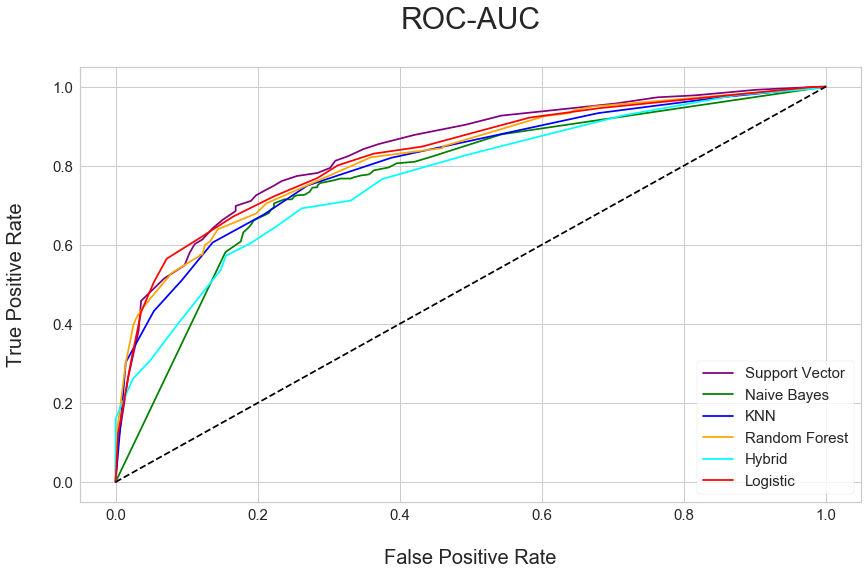

<Figure size 576x396 with 0 Axes>

In [28]:
fig = plt.figure(figsize = [14,8])

fig.patch.set_alpha(0.)

svc_line = plt.plot(x_plt_svc, y_plt_svc, color='purple', label='Support Vector')
nb_line = plt.plot(x_plt_nb, y_plt_nb, color='green', label='Naive Bayes')
knn_line = plt.plot(x_plt_knn, y_plt_knn, color='blue', label='KNN')

rf_line = plt.plot(x_plt_rf, y_plt_rf, color='orange', label='Random Forest')
hybrid_line = plt.plot(x_plt_hybrid, y_plt_hybrid, color='cyan', label='Hybrid')

log_line = plt.plot(x_plt_log, y_plt_log, color='red', label='Logistic')

plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate', size=20)
plt.ylabel('True Positive Rate\n', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('ROC-AUC\n', size=30)
plt.legend(loc='lower right', fontsize=15, frameon=True)
plt.show()
plt.savefig('ROC_all.png')

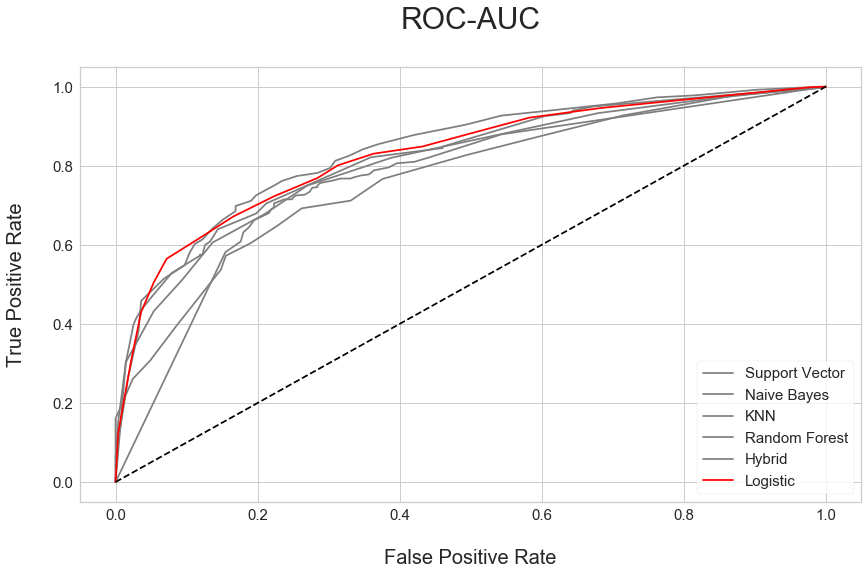

<Figure size 576x396 with 0 Axes>

In [29]:
fig = plt.figure(figsize = [14,8])

fig.patch.set_alpha(0.)


svc_line = plt.plot(x_plt_svc, y_plt_svc, color='tab:gray', label='Support Vector')
nb_line = plt.plot(x_plt_nb, y_plt_nb, color='tab:gray', label='Naive Bayes')
knn_line = plt.plot(x_plt_knn, y_plt_knn, color='tab:gray', label='KNN')

rf_line = plt.plot(x_plt_rf, y_plt_rf, color='tab:gray', label='Random Forest')
hybrid_line = plt.plot(x_plt_hybrid, y_plt_hybrid, color='tab:gray', label='Hybrid')
log_line = plt.plot(x_plt_log, y_plt_log, color='red', label='Logistic')
plt.plot([0,1],[0,1], color='black', linestyle='--')
plt.xlabel('\nFalse Positive Rate', size=20)
plt.ylabel('True Positive Rate\n', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('ROC-AUC\n', size=30)
plt.legend(loc='lower right', fontsize=15, frameon=True)
plt.show()
plt.savefig('ROC_logistic_hilite.png')

In [30]:
# Generate the data for the precision/recall graphx
prec_dat, recall_dat, thresh_list = calc_pr_sweep(log_best.predict_proba, X_test, y_test, 40)

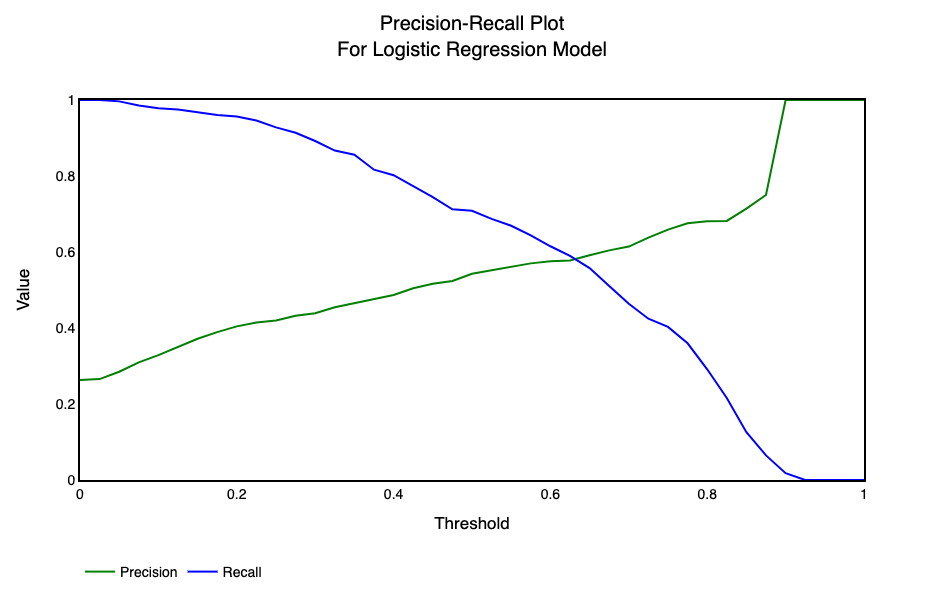

In [46]:
layout = go.Layout(paper_bgcolor = 'rgba(0,0,0,0)', 
            plot_bgcolor = 'rgba(0,0,0,0)',
            width=800, height=600)

fig = go.Figure(layout=layout)

fig.add_trace(go.Line(x=thresh_list, y=prec_dat, mode='lines', name='Precision', line=dict(color='green', width=2)))
fig.add_trace(go.Line(x=thresh_list, y=recall_dat, mode='lines', name='Recall', line=dict(color='blue', width=2)))


fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, showgrid=False, zeroline=False, range=[0,1])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True, showgrid=False, zeroline=False, range=[0,1])


fig.update_layout(
    title={
        'text': "Precision-Recall Plot<br>For Logistic Regression Model",
        'x': 0.5, 'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'},
    
        font=dict(
            family="Helvetica",
            size=20,
            color="black"
        ))

fig.update_layout(legend_orientation = 'h',
        legend=dict(x=0, y=-.2),
        xaxis_title =  "Threshold\n",
        yaxis_title="Value",
        font=dict(
            family="Helvetica",
            size=14,
            color="black"
        ))

                    
fig.show(render='png')

Select Logistic Regression based on the performance in the chart above